In [27]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import fft
from mpl_toolkits.mplot3d import Axes3D
from scipy.signal import butter, filtfilt

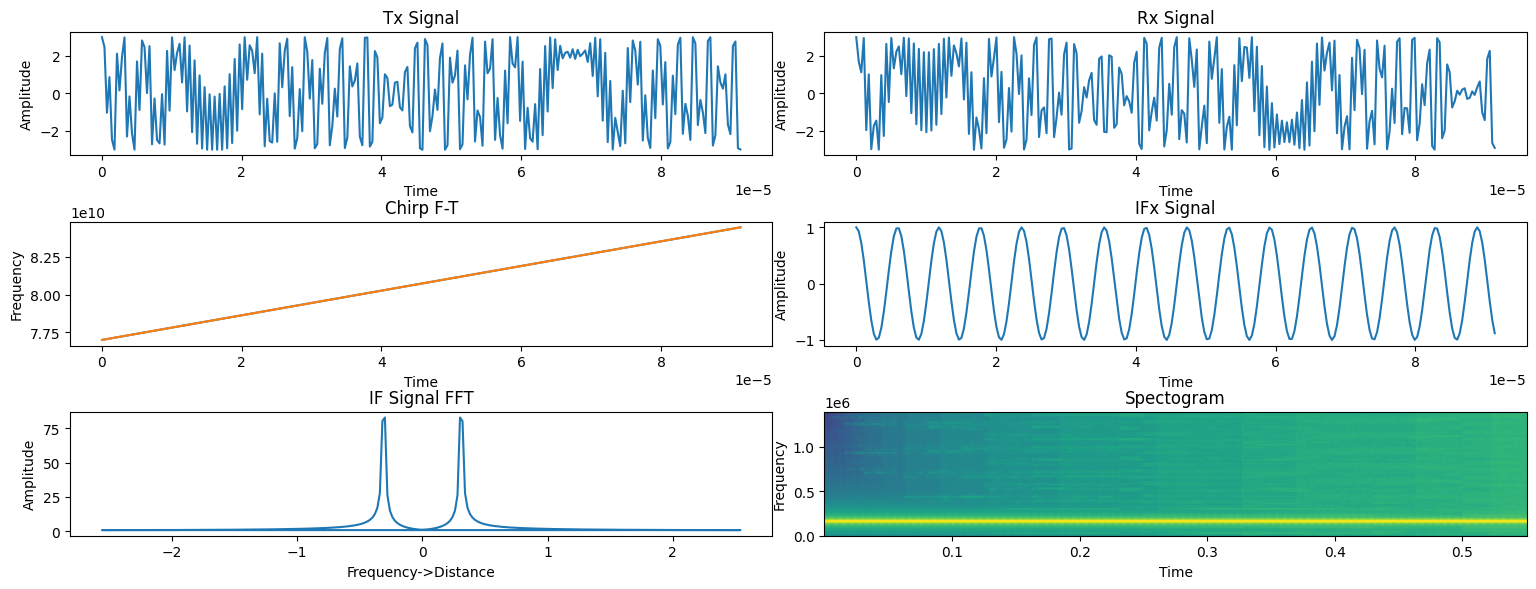

In [28]:
#Radar parameters setting

maxR = 11
maxV = 70 
fc = 77e9 #Carrier frequency
c = 3e8 

r0 = 0.3 #target distance
v0 = 0 #target velocity

B=7.5 * (1e9)
rangeRes = c/(2*B)

# rangeRes = 0.02
# B = c/(2*rangeRes)

Tchirp = 91.72 * (1e-6)
endle_time = 6.3e-6
slope = B/Tchirp 
f_IFmax = (slope*2*maxR)/c
f_IF = (slope*2*r0)/c 

Nd =  6000 # number of chirp
Nr = 256 #number of sample per chirp

SAMPLE_COUNT_CHIRP =256

vres = (c/fc)/(2*Nd*(Tchirp+endle_time)) 

Fs = Nr/Tchirp  #Sampling rate

amplitude_TX=3
amplitude_RX=3

t = np.linspace(0,Nd*Tchirp,Nr*Nd,endpoint=False) 

angle_freq = fc*t+(slope*t*t)/2 
freq = fc + slope*t 
Tx = amplitude_TX *np.cos(2*np.pi*angle_freq)

plt.figure(figsize=(16,8))

plt.subplot(4,2,1)
plt.plot(t[0:SAMPLE_COUNT_CHIRP],Tx[0:SAMPLE_COUNT_CHIRP])
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Tx Signal')
plt.subplot(4,2,3)
plt.plot(t[0:SAMPLE_COUNT_CHIRP],freq[0:SAMPLE_COUNT_CHIRP])
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Tx F-T')

r0 = r0+v0*t
td = 2*r0/c
tx = t
freqRx = fc + slope*(t)

breathing_freq = 0.3  # Frequency in Hz
heart_freq = 2  # Frequency in Hz
vibration_amplitude_mm = 0.04  # Amplitude of the signal
vibration_amplitude_mm_heart = 0.01  # Amplitude of the signal
duration = 300  # Duration in seconds
sampling_rate = 20*256  # Sampling rate in Hz

# Time array
breath_time = np.arange(0, duration, 1 / sampling_rate)
heart_time = np.arange(0, duration, 1 / sampling_rate)

# Calculate target vibration displacement profile (using a sinusoidal function for breathing-like motion)
vibration_displacement = vibration_amplitude_mm * np.sin(2 * np.pi * breathing_freq * breath_time)
vibration_displacement_heart = vibration_amplitude_mm_heart * np.sin(2 * np.pi * heart_freq * heart_time)

# Calculate the phase shift for the vibration effect in received signal
Rx = amplitude_RX *np.cos(2*np.pi*(fc*(t-td) + (slope*(t-td)*(t-td))/2)) #接受波形函数

plt.subplot(4,2,2)
plt.plot(t[0:SAMPLE_COUNT_CHIRP],Rx[0:SAMPLE_COUNT_CHIRP])
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Rx Signal')
plt.subplot(4,2,3)
plt.plot(t[0:SAMPLE_COUNT_CHIRP]+td[0:SAMPLE_COUNT_CHIRP],freqRx[0:SAMPLE_COUNT_CHIRP])
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Chirp F-T')

phase_shift=0
phase_shift+=(4 * np.pi * (r0+vibration_displacement))/0.04 
phase_shift +=(4 * np.pi * (r0+vibration_displacement_heart))/0.04
IF_angle_freq = fc*t+(slope*t*t)/2 - ((fc*(t-td) + (slope*(t-td)*(t-td))/2))
freqIF = slope*td
IFx = np.cos(-(2*np.pi*(fc*(t-td) + (slope*(t-td)*(t-td))/2))+(2*np.pi*angle_freq)+phase_shift)

plt.subplot(4,2,4)
plt.plot(t[0:SAMPLE_COUNT_CHIRP],IFx[0:SAMPLE_COUNT_CHIRP])
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('IFx Signal')

#Range FFT

doppler = np.abs(np.fft.fft(IFx[0:SAMPLE_COUNT_CHIRP]))
frequency = np.fft.fftfreq(SAMPLE_COUNT_CHIRP, 1/Fs)
range_freq = frequency*c/(2*slope)
plt.subplot(4,2,5)
plt.plot(range_freq[0:SAMPLE_COUNT_CHIRP],doppler[0:SAMPLE_COUNT_CHIRP])
plt.xlabel('Frequency->Distance')
plt.ylabel('Amplitude')
plt.title('IF Signal FFT')

#2D plot
plt.subplot(4,2,6)
plt.specgram(IFx,SAMPLE_COUNT_CHIRP,Fs)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Spectogram')

plt.tight_layout(pad=3, w_pad=0.05, h_pad=0.05)
plt.show()



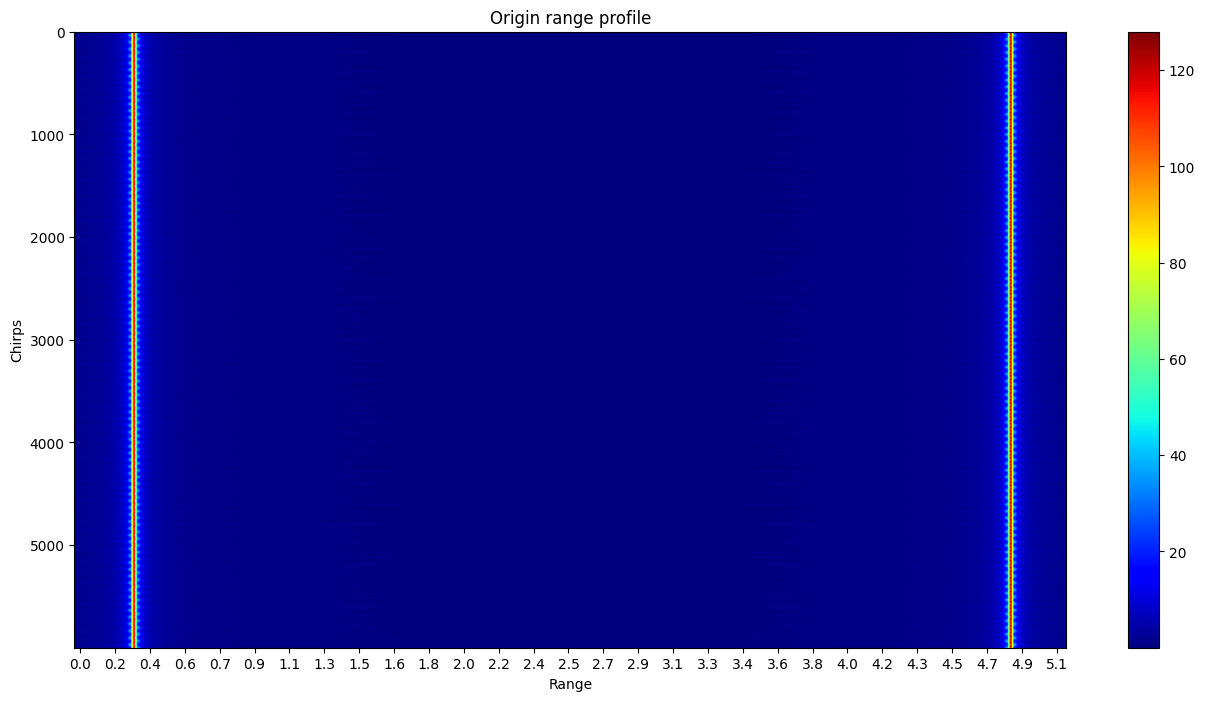

In [29]:
IFMatrix =IFx.reshape(Nd,Nr)
rangeProfiles =np.fft.fft (IFMatrix,axis=1)
magnitude_range_profile = [np.abs(profile) for profile in rangeProfiles]
# freqs = np.fft.fftfreq(len(rangeProfiles[0]), 1/Fs)
# doppler = np.abs(np.fft.fft(IFx[0:SAMPLE_COUNT_CHIRP]))
# frequency = np.fft.fftfreq(SAMPLE_COUNT_CHIRP, 1/Fs)
range_fre = frequency*c/(2*slope)
rangeBinDistance = [round(j*rangeRes,1) for j in range(1,Nr,9) ]

plt.figure(figsize=(16,8))
plt.xlabel('Range')
plt.ylabel('Chirps')
plt.imshow(magnitude_range_profile,aspect='auto',cmap='jet')
plt.colorbar()
# plt.xticks(rangeBinDistance)
plt.xticks(range(1,Nr,9), rangeBinDistance)
plt.title("Origin range profile")
plt.show()


In [30]:
# range_profile_shape = np.array(rangeProfiles).shape
# range_bin = range_profile_shape[1]
# frame_number =range_profile_shape[0]

# estimated_background_range_profile = np.zeros(range_bin,dtype=complex)
# for bin_index in range (0,range_bin):
#     estimated_background_range_profile[bin_index] = np.average(np.array(rangeProfiles)[:,bin_index])
# print("background estimation: ",estimated_background_range_profile.shape)

# removal_background_range_profile =np.zeros_like(rangeProfiles)
# for  bin_index in range (0,range_bin):
#     for frame_index in range(0,frame_number):
#         removal_background_range_profile [frame_index][bin_index] = rangeProfiles[frame_index][bin_index] - estimated_background_range_profile[bin_index]
# print("background removal range profile: ",removal_background_range_profile.shape)   
# magnitude_range_profile = [np.abs(profile) for profile in removal_background_range_profile]
# doppler = np.abs(np.fft.fft(IFx[0:SAMPLE_COUNT_CHIRP]))
# frequency = np.fft.fftfreq(SAMPLE_COUNT_CHIRP, 1/Fs)
# range_fre = frequency*c/(2*slope)
# rangeBinDistance = [round(j*rangeRes,1) for j in range(1,Nr,9) ]

# plt.figure(figsize=(16,8))
# plt.imshow(magnitude_range_profile,aspect='auto',cmap='jet')
# plt.xticks(range(1,Nr,9), rangeBinDistance)
# plt.title("Origin range profile")
# plt.show()


In [31]:
magnitude_range_profile_shape =np.array(magnitude_range_profile).shape
max_indices =[0]*magnitude_range_profile_shape[0]
for mag_profile in magnitude_range_profile:
    max_index = np.argmax(mag_profile)
    max_indices[max_index]+=1
interesting_bin =np.argmax(max_indices)
print(interesting_bin)

15


In [32]:
def extractPhase(interestingRangeBin):
    interestingRangeBinLen =len(interestingRangeBin)
    phaseExtracted = np.zeros(len(interestingRangeBin),dtype=float)
    phaseExtracted[0]=np.angle(interestingRangeBin[0])
    
    for i in range(1,interestingRangeBinLen):        
        tmpPhase =0
        for j in range(1,i):
            I_k=interestingRangeBin[j].real
            Q_k=interestingRangeBin[j].imag
            I_k_prev=interestingRangeBin[j-1].real
            Q_k_prev=interestingRangeBin[j-1].imag
            tmpPhase+= (I_k * (Q_k - Q_k_prev) -(I_k - I_k_prev)* Q_k)/(I_k**2 + Q_k **2)

        phaseExtracted[i]= tmpPhase
    return phaseExtracted

In [46]:
unwrapped_phase_DACM= extractPhase(np.array(rangeProfiles)[:,interesting_bin])

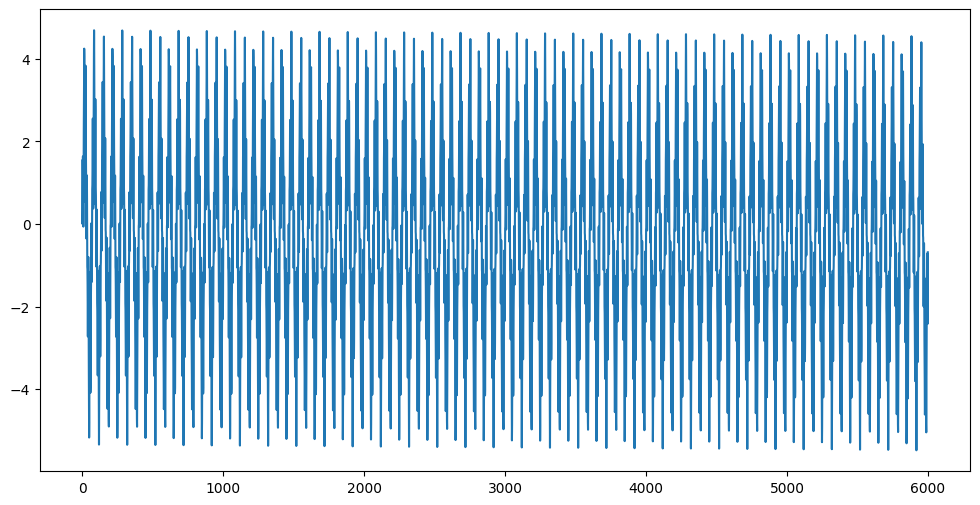

In [47]:
plt.figure(figsize=(12,6))
plt.plot(unwrapped_phase_DACM)
plt.show()

In [ ]:
window = np.hamming(len(unwrapped_phase_DACM))

# Apply window to the signal
windowed_signal = unwrapped_phase_DACM * window

plt.figure(figsize=(12,6))
plt.plot(windowed_signal)
plt.show()

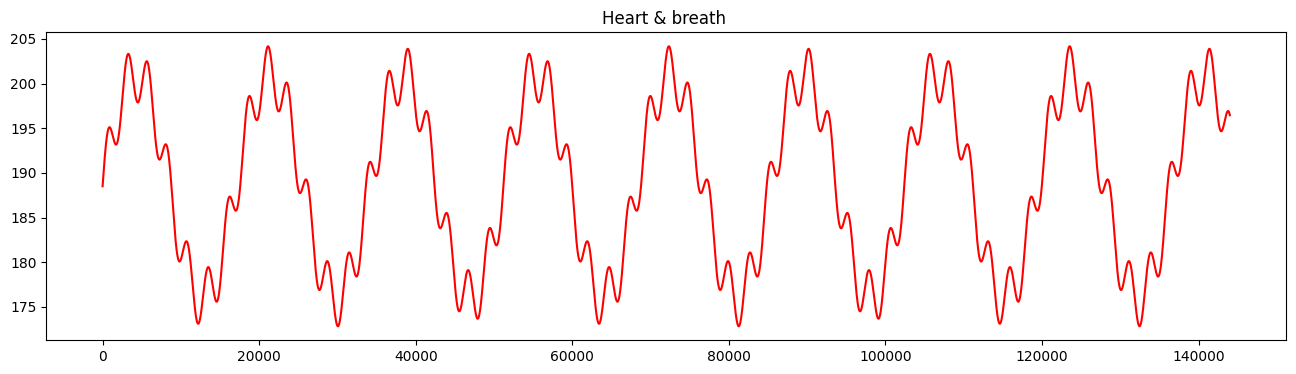

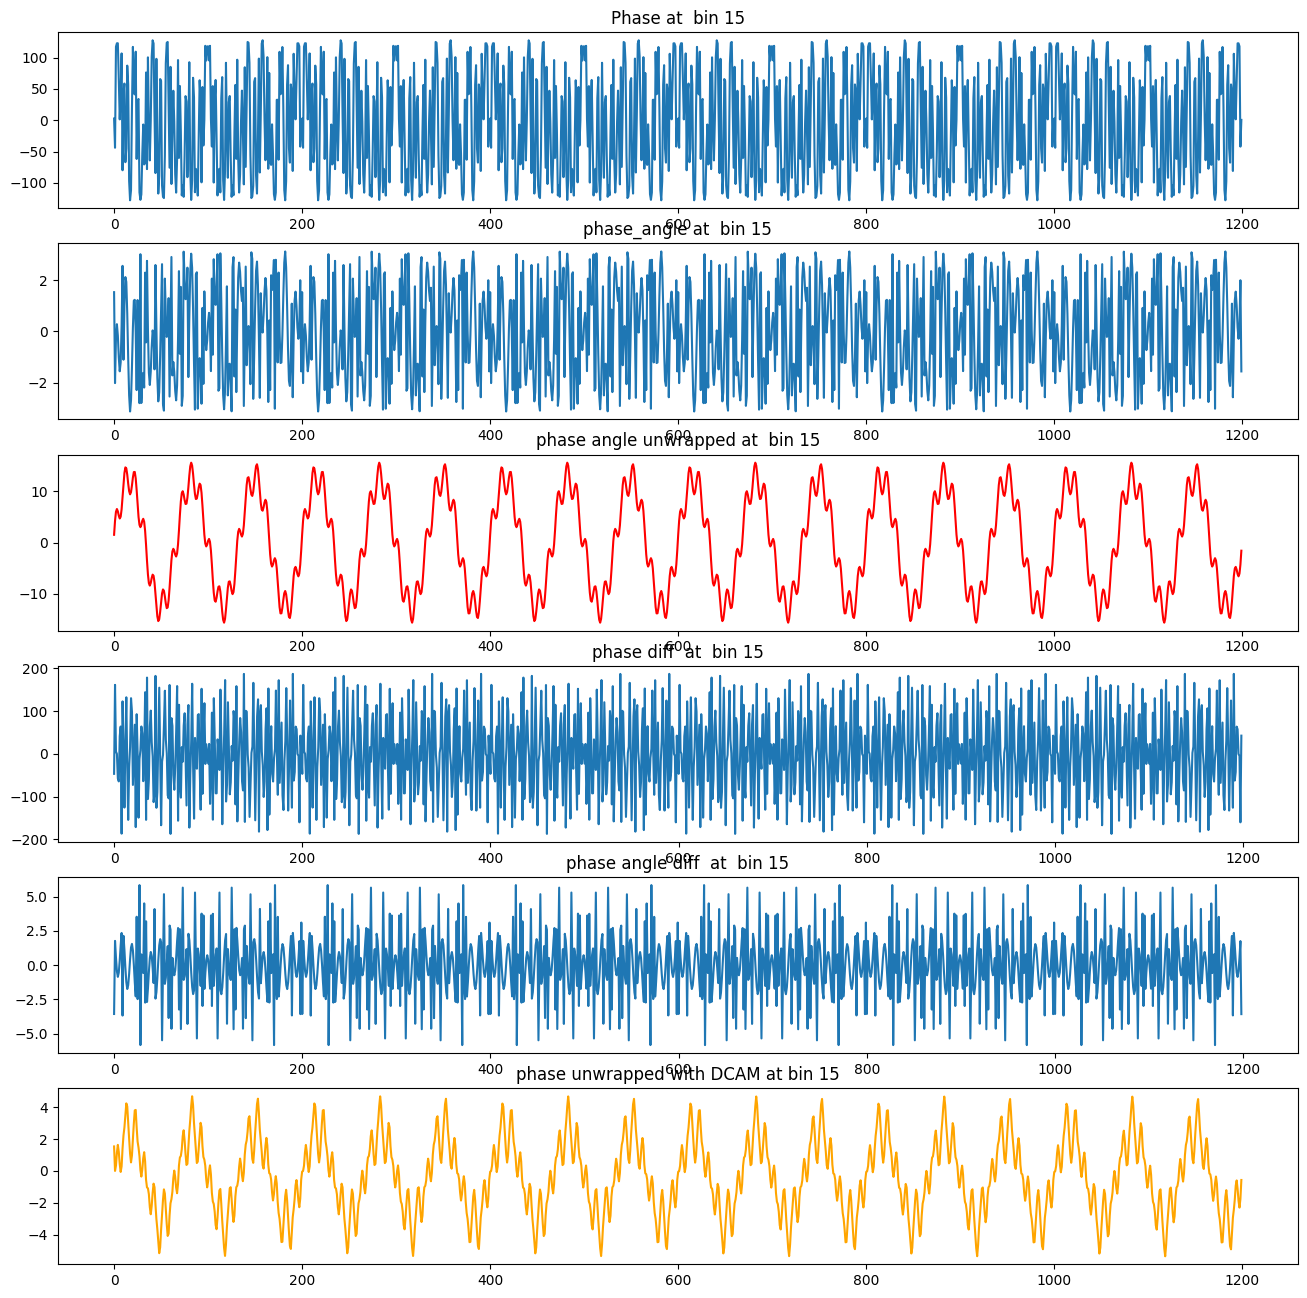

In [48]:
interest_bin_phase = np.array(rangeProfiles)[:,interesting_bin]
interest_bin_phase=interest_bin_phase[:1200]
phase_angle = np.angle(interest_bin_phase)
phase_angle_unwrapped = np.unwrap(phase_angle)
phase_diff =np.diff(interest_bin_phase)
phase_angle_diff =np.diff(phase_angle)


plt.figure(figsize=(16,4))
plt.plot(phase_shift[:(1200*120)],color="red")
plt.title("Heart & breath ")
plt.show()

plt.figure(figsize=(16,16))
plt.subplot(611)
plt.plot(interest_bin_phase)
plt.title("Phase at  bin {0}".format(interesting_bin))
plt.subplot(612)
plt.plot(phase_angle)
plt.title("phase_angle at  bin {0}".format(interesting_bin))
plt.subplot(613)
plt.plot(phase_angle_unwrapped,color="red")
plt.title("phase angle unwrapped at  bin {0}".format(interesting_bin))
plt.subplot(614)
plt.plot(phase_diff)
plt.title("phase diff  at  bin {0}".format(interesting_bin))
plt.subplot(615)
plt.plot(phase_angle_diff)
plt.title("phase angle diff  at  bin {0}".format(interesting_bin))


plt.subplot(616)
plt.plot(unwrapped_phase_DACM[0:1200],color="orange")
plt.title("phase unwrapped with DCAM at bin {0}".format(interesting_bin))

plt.show()

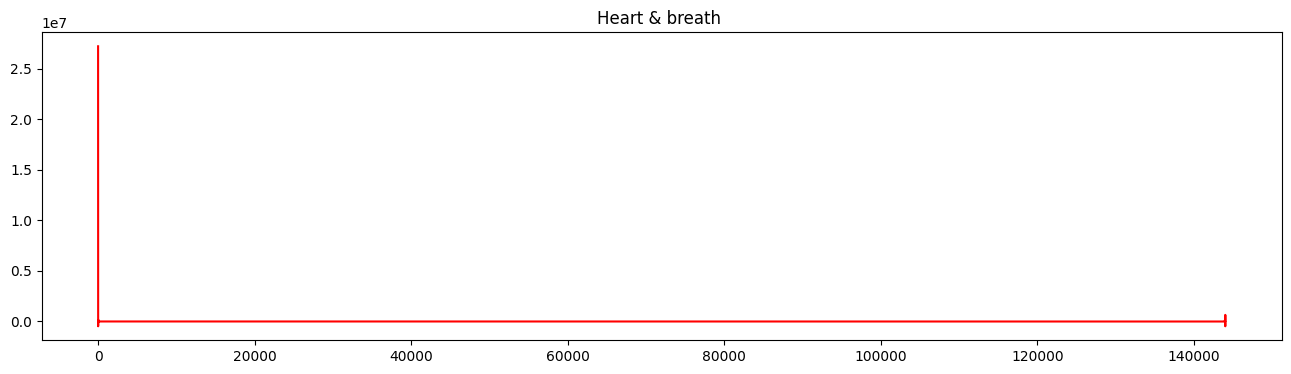

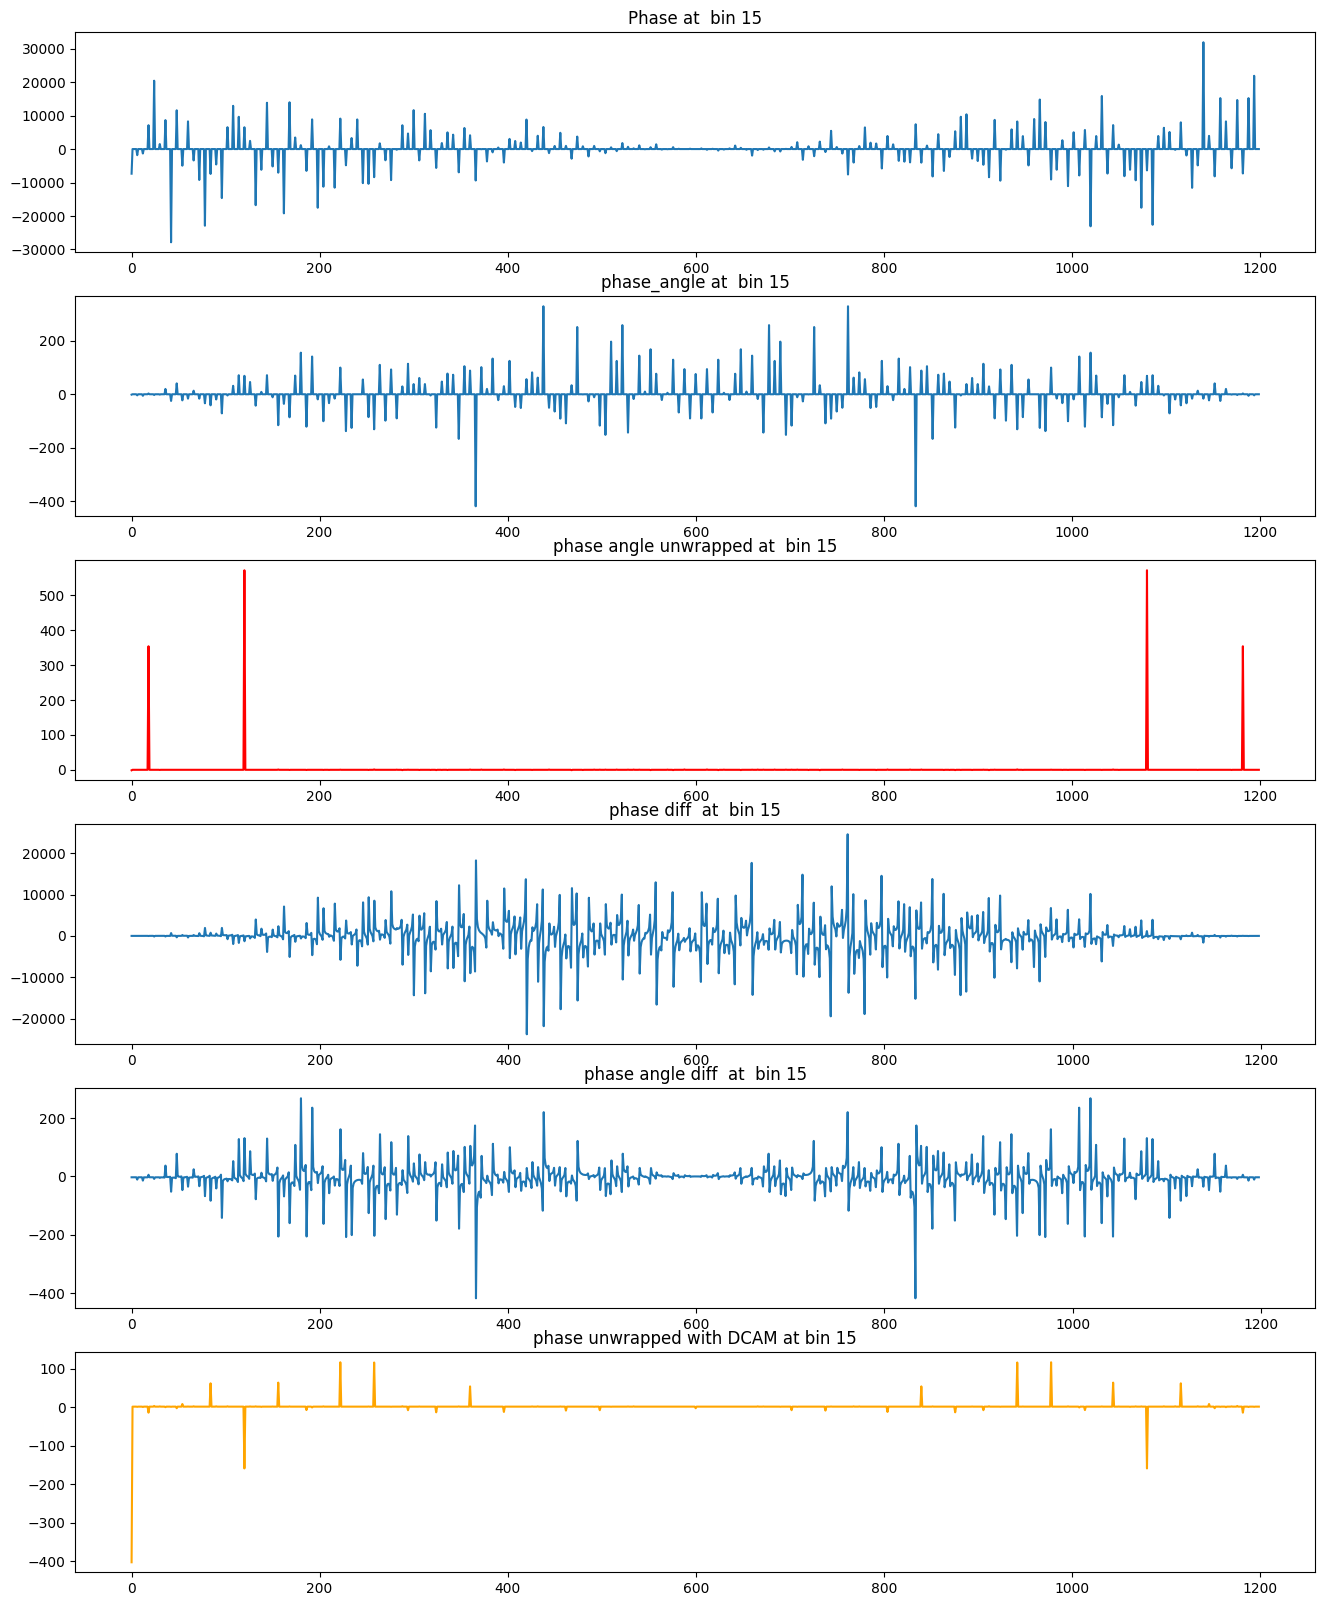

In [49]:

plt.figure(figsize=(16,4))
plt.plot(np.fft.fft(phase_shift[:(1200*120)]),color="red")
plt.title("Heart & breath ")
plt.show()

plt.figure(figsize=(16,20))
plt.subplot(611)
plt.plot(np.fft.fft(interest_bin_phase))
plt.title("Phase at  bin {0}".format(interesting_bin))
plt.subplot(612)
plt.plot(np.fft.fft(phase_angle))
plt.title("phase_angle at  bin {0}".format(interesting_bin))
plt.subplot(613)
plt.plot(np.fft.fft(phase_angle_unwrapped),color="red")
plt.title("phase angle unwrapped at  bin {0}".format(interesting_bin))
plt.subplot(614)
plt.plot(np.fft.fft(phase_diff))
plt.title("phase diff  at  bin {0}".format(interesting_bin))
plt.subplot(615)
plt.plot(np.fft.fft(phase_angle_diff))
plt.title("phase angle diff  at  bin {0}".format(interesting_bin))


plt.subplot(616)
plt.plot(np.fft.fft(unwrapped_phase_DACM[0:1200]),color="orange")
plt.title("phase unwrapped with DCAM at bin {0}".format(interesting_bin))
plt.show()


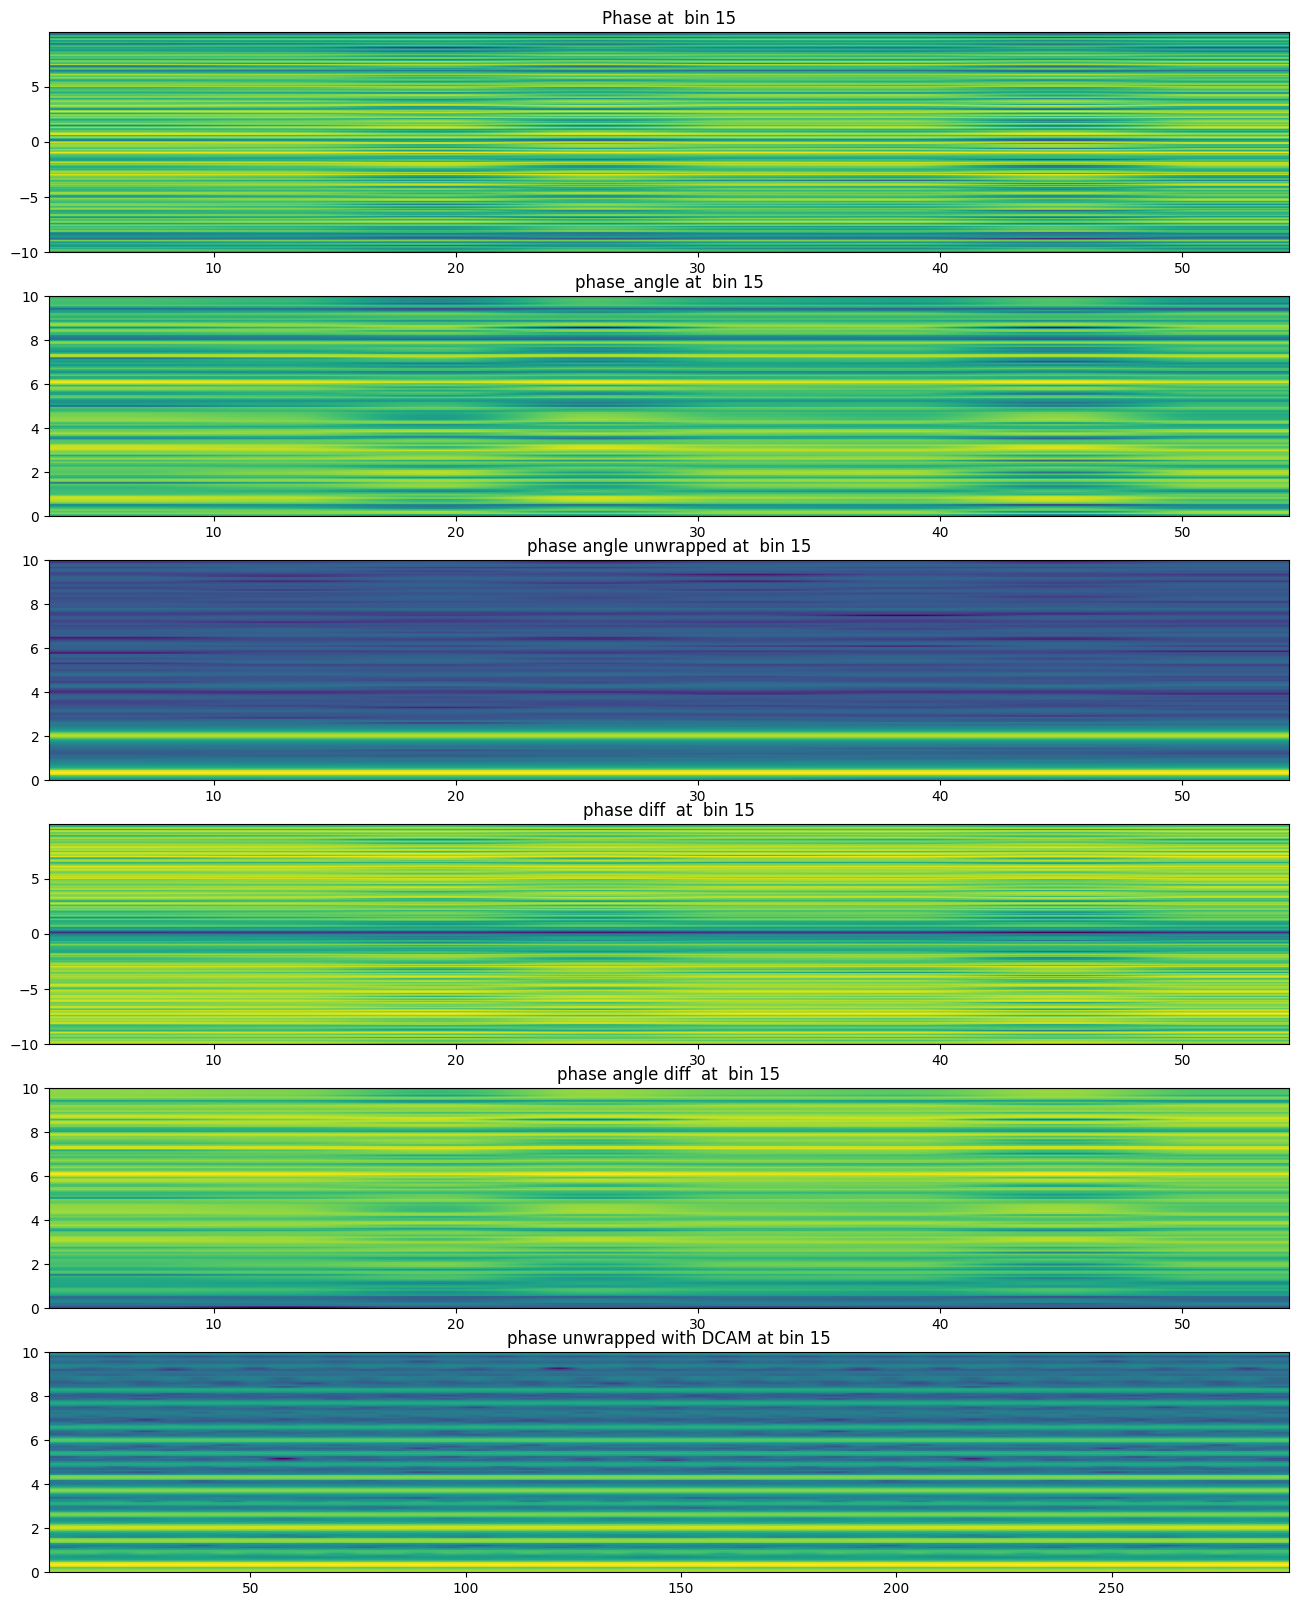

In [50]:
plt.figure(figsize=(16,20))
plt.subplot(611)
plt.specgram(interest_bin_phase,Fs=20)
plt.title("Phase at  bin {0}".format(interesting_bin))
plt.subplot(612)
plt.specgram(phase_angle,Fs=20)
plt.title("phase_angle at  bin {0}".format(interesting_bin))
plt.subplot(613)
plt.specgram(phase_angle_unwrapped,Fs=20)
plt.title("phase angle unwrapped at  bin {0}".format(interesting_bin))
plt.subplot(614)
plt.specgram(phase_diff,Fs=20)
plt.title("phase diff  at  bin {0}".format(interesting_bin))
plt.subplot(615)
plt.specgram(phase_angle_diff,Fs=20)
plt.title("phase angle diff  at  bin {0}".format(interesting_bin))


plt.subplot(616)
plt.specgram(unwrapped_phase_DACM,Fs=20)
plt.title("phase unwrapped with DCAM at bin {0}".format(interesting_bin))

plt.show()

In [51]:
def filter_signal (signal_to_filter ,_low_freq,_high_freq,_sampling_rate,_filter_order):
    sampling_rate = _sampling_rate# Sampling rate of the input signal
    low_freq = _low_freq  # Lower cutoff frequency of the bandpass filter
    high_freq = _high_freq  # Upper cutoff frequency of the bandpass filter
    filter_order = _filter_order # Order of the bandpass filter

    # Compute the normalized cutoff frequencies
    nyquist_freq = 0.5 * sampling_rate
    low_norm = low_freq / nyquist_freq
    high_norm = high_freq / nyquist_freq
    
    # Design the bandpass filter
    b, a = butter(filter_order, [low_norm, high_norm], btype='band')

    # Apply the bandpass filter to the input signal
    signal_filtered = filtfilt(b, a, signal_to_filter)
    return signal_filtered

Text(0.5, 1.0, 'interest_bin_angle_unwrapped')

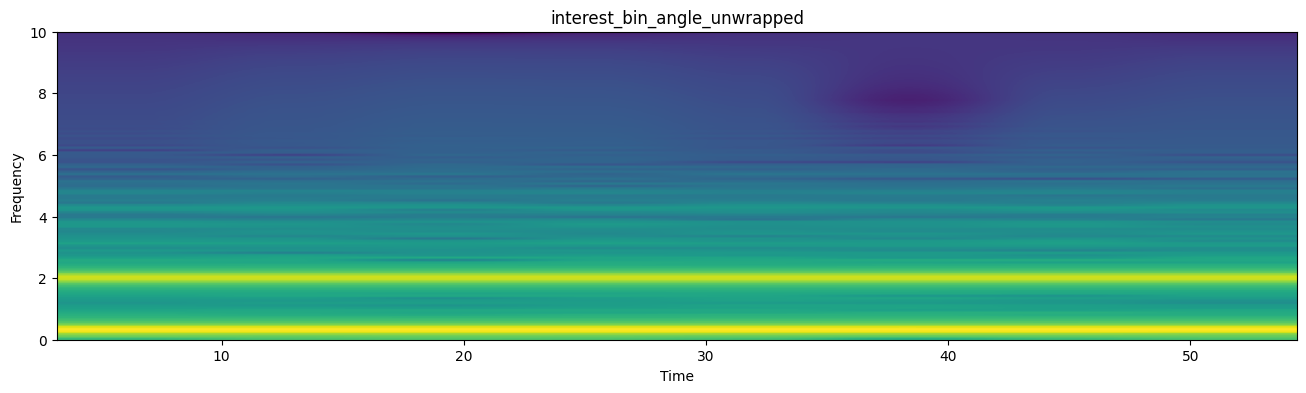

In [52]:
SR=1200/60
breath_heart_band_filtering=[0.2,4]
filtered_signal =filter_signal(np.array(phase_angle_unwrapped),breath_heart_band_filtering[0],breath_heart_band_filtering[1],SR,4)
plt.figure(figsize=(16,4))
plt.specgram(filtered_signal,Fs=20)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('interest_bin_angle_unwrapped')

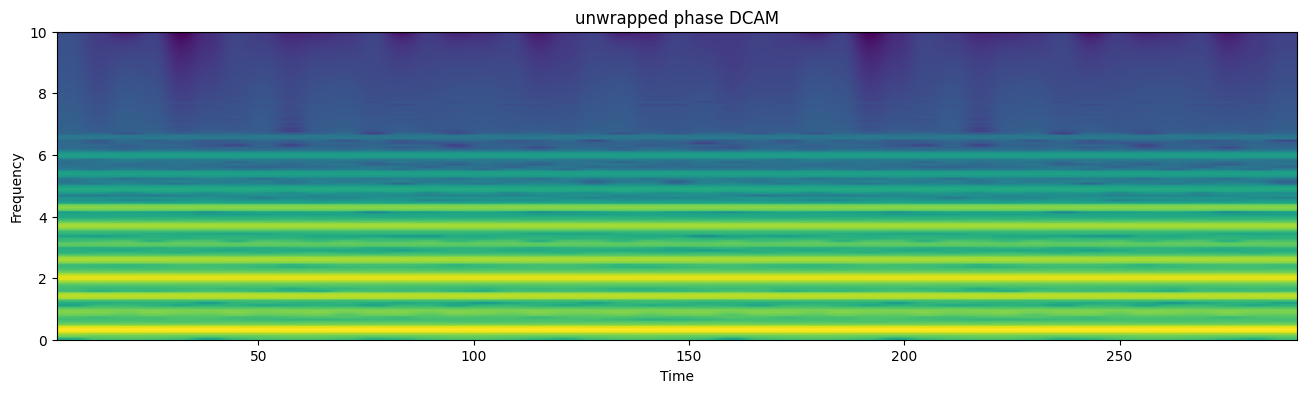

In [53]:
SR=1200/60
breath_heart_band_filtering=[0.2,4]
DACM_filtered_signal =filter_signal(np.array(unwrapped_phase_DACM),breath_heart_band_filtering[0],breath_heart_band_filtering[1],SR,4)
plt.figure(figsize=(16,4))
plt.specgram(DACM_filtered_signal,Fs=20)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('unwrapped phase DCAM')
plt.show()